In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import numpy as np
import joblib

### Data loading

In [2]:
path = "./Datasets/CIFAR10_data/"
# path = "E:/Datasets/CIFAR10_data/"

device = 'cuda'
num_workers = 0
batch_size = 64

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.CIFAR10(path, train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(path, train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

classes = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

0it [00:00, ?it/s]

170500096it [00:06, 27569495.91it/s]                               


Extracting ./Datasets/CIFAR10_data/cifar-10-python.tar.gz to ./Datasets/CIFAR10_data/
Files already downloaded and verified


### Network

In [0]:
class Architecture(nn.Module):
    def __init__(self):
        super(Architecture, self).__init__()

        self.encoder_conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.encoder_conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.encoder_conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, return_indices=True)

        self.decoder_conv1 = nn.ConvTranspose2d(128, 64, 3, padding=1)
        self.decoder_conv2 = nn.ConvTranspose2d(64, 32, 3, padding=1)
        self.decoder_conv3 = nn.ConvTranspose2d(32, 3, 3, padding=1)
        self.unpool = nn.MaxUnpool2d(2)

        self.encoder_fc1 = nn.Linear(128 * 4 * 4, 256)
        self.encoder_fc2 = nn.Linear(256, 64)
        self.encoder_fc3 = nn.Linear(64, 10)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.encoder_conv1(x))
        x, indices1 = self.pool(x)

        x = self.relu(self.encoder_conv2(x))
        x, indices2 = self.pool(x)  # 16->8

        x = self.relu(self.encoder_conv3(x))
        encoded, indices3 = self.pool(x)

        x = self.unpool(encoded, indices3)  # 4->8
        x = self.relu(self.decoder_conv1(x))  # 8->8

        x = self.unpool(x, indices2)  # 8->16
        x = self.relu(self.decoder_conv2(x))  # 16->16

        x = self.unpool(x, indices1)  # 16->32  ==>3*32*32
        decoded = self.relu(self.decoder_conv3(x))  # 32->32

        encoded = encoded.view(-1, 128 * 4 * 4)
        encoded = self.relu(self.encoder_fc1(encoded))
        encoded = self.relu(self.encoder_fc2(encoded))
        encoded = self.encoder_fc3(encoded)

        return encoded, decoded

model = Architecture()
model.to(device)

CE = nn.CrossEntropyLoss()
MSE = nn.MSELoss()
optimizer = optim.Adagrad(model.parameters(), lr=0.02)

### Training, Testing and train,valid-loss, test-accuracy

In [10]:
train_mse_loss_plt = []
train_ce_loss_plt = []
test_accuracy_plt = []
test_loss_plt = []

n_epochs = 100
for epoch in range(n_epochs):
    train_ce_loss = 0
    train_mse_loss = 0
    test_loss = 0

    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        en, de = model(images)

        classification_loss = CE(en, labels)
        reconstruction_loss = MSE(de, images)

        classification_loss.backward(retain_graph=True)
        reconstruction_loss.backward(retain_graph=True)

        optimizer.step()

        train_ce_loss += classification_loss.item() * images.size(0)
        train_mse_loss += reconstruction_loss.item() * images.size(0)

    train_ce_loss /= len(train_loader.dataset)
    train_mse_loss /= len(train_loader.dataset)
    
    train_mse_loss_plt.append(train_mse_loss)
    train_ce_loss_plt.append(train_ce_loss)

    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            en, de = model(data)
            loss = CE(en, target)

            test_loss += loss.item() * data.size(0)
            _, pred = torch.max(en, 1)
            correct = np.squeeze(pred.eq(target.data.view_as(pred)))
            for i in range(len(target)):
                label = target.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    test_loss = test_loss / len(test_loader.dataset)
    test_loss_plt.append(test_loss)
    test_accuracy = 100. * np.sum(class_correct) / np.sum(class_total)
    test_accuracy_plt.append(test_accuracy)
    print('Epoch:',(epoch + 1),'\tTrain MSELoss:',train_mse_loss,' | Train CELoss:', train_ce_loss,' | Test Loss:',test_loss,' Test Accuracy:', test_accuracy)

Epoch: 1 	Train MSELoss: 0.17000585839033128  | Train CELoss: 1.607294767074585  | Test Loss: 1.4115949542999267  Test Accuracy: 46.82
Epoch: 2 	Train MSELoss: 0.15603245544195174  | Train CELoss: 1.1671999194335938  | Test Loss: 1.166077950668335  Test Accuracy: 58.04
Epoch: 3 	Train MSELoss: 0.15433473869085312  | Train CELoss: 0.9990653388977051  | Test Loss: 1.016939252090454  Test Accuracy: 64.21
Epoch: 4 	Train MSELoss: 0.15331913217782975  | Train CELoss: 0.8907336264801026  | Test Loss: 0.936101914024353  Test Accuracy: 67.13
Epoch: 5 	Train MSELoss: 0.15260012696504593  | Train CELoss: 0.8157016567993164  | Test Loss: 0.9033882164955139  Test Accuracy: 68.36
Epoch: 6 	Train MSELoss: 0.15203326902151107  | Train CELoss: 0.7574558624076844  | Test Loss: 0.8727810871124267  Test Accuracy: 69.78
Epoch: 7 	Train MSELoss: 0.1515632546710968  | Train CELoss: 0.7097197657775879  | Test Loss: 0.853812021446228  Test Accuracy: 70.75
Epoch: 8 	Train MSELoss: 0.15113413756132127  | Train 

### Saving

In [0]:
joblib.dump(train_ce_loss_plt, 'train_ce_loss_plt_q1.sav')
joblib.dump(train_mse_loss_plt, 'train_mse_loss_plt_q1.sav')
joblib.dump(test_loss_plt, 'test_loss_plt_q1.sav')
joblib.dump(test_accuracy_plt, 'test_accuracy_plt_q1.sav')
torch.save(model.state_dict(), "model_q1.pt")

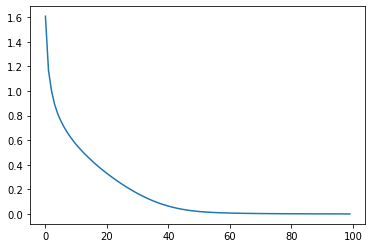

In [13]:
plt.plot(np.arange(len(train_ce_loss_plt)),train_ce_loss_plt)

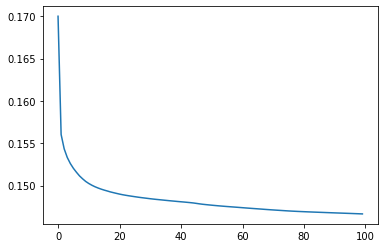

In [14]:
plt.plot(np.arange(len(train_mse_loss_plt)),train_mse_loss_plt)

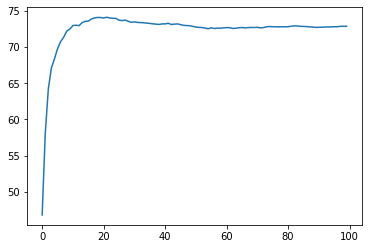

In [15]:
plt.plot(np.arange(len(test_accuracy_plt)),test_accuracy_plt)

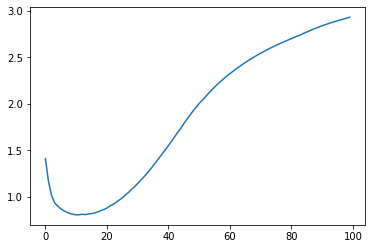

In [16]:
plt.plot(np.arange(len(test_loss_plt)),test_loss_plt)

In [29]:
train_ce_loss_plt = joblib.load('train_ce_loss_plt_q1.sav')
train_mse_loss_plt = joblib.load('train_mse_loss_plt_q1.sav')
test_accuracy_plt = joblib.load('test_accuracy_plt_q1.sav')
test_loss_plt = joblib.load('test_loss_plt_q1.sav')

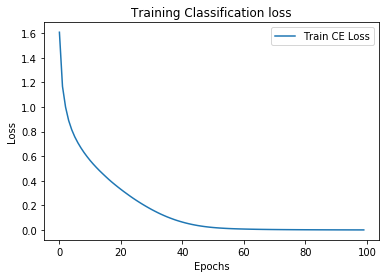

In [30]:
plt.title('Training Classification loss')
plt.plot(np.arange(len(train_ce_loss_plt)),train_ce_loss_plt,label = 'Train CE Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

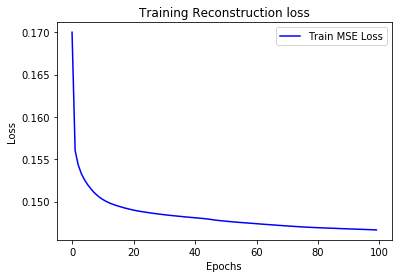

In [31]:
plt.title('Training Reconstruction loss')
plt.plot(np.arange(len(train_mse_loss_plt)),train_mse_loss_plt,color='b',label = 'Train MSE Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

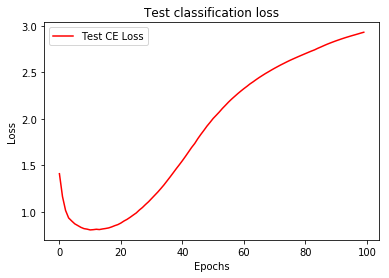

In [40]:
plt.title('Test classification loss')
plt.plot(np.arange(len(test_loss_plt)),test_loss_plt,color='r',label = 'Test CE Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

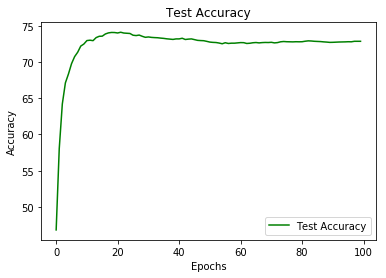

In [38]:
plt.title('Test Accuracy')
plt.plot(np.arange(len(test_accuracy_plt)),test_accuracy_plt,color='g',label = 'Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()